In [1]:
%matplotlib inline
from solveLongRanged import linearSolve_krylov as linearSolve
#from solve2sDirect import linearSolve_direct ## all symmetry factors
#from solve2s import linearSolve_krylov       ## only VL symmetry factors
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(6*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] - 1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
        S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [20]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [48]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 500.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 2min 17s, sys: 92.5 ms, total: 2min 17s
Wall time: 1min 47s


'The solver successfully reached the end of the integration interval.'

In [49]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [50]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

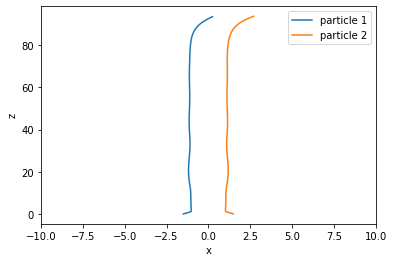

In [51]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim(-10,10)
plt.legend()
plt.show()

In [52]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.043930204658359, 3.0)

In [53]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([14]),)

In [54]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.043930204658359, -4.589101141651591e-25, 9.743317264110374e-13)

In [55]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [56]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  2.22044605e-16 -2.22044605e-16 -6.66133815e-15
 -1.03494990e-12 -2.67408318e-12 -2.41828779e-12 -1.50301993e-12
 -1.07402975e-12 -1.49902313e-12 -3.46611628e-12 -5.19384535e-12
 -4.90607555e-12 -1.67510450e-12  5.37414557e-12  7.71716024e-12
  9.21618337e-12  1.07289733e-11  1.33890676e-11  1.73181469e-11
  2.57589505e-11  3.67212927e-11  5.05189224e-11  6.77700118e-11
  1.24448896e-10  2.09338324e-10  3.30372174e-10  4.98113772e-10
  9.13198850e-10  1.56542290e-09  2.54677923e-09  3.96548905e-09
  5.94729643e-09  9.30265220e-09  1.40283265e-08  2.05785078e-08
  2.96146383e-08  4.98872721e-08  8.44833783e-08  1.46649124e-07
  2.85025037e-07  5.72683506e-07  1.16711143e-06  2.04250826e-06
  3.51912055e-06  5.95829068e-06  9.93928295e-06  1.79784706e-05
  3.25511869e-05  5.96274469e-05  1.11087271e-04  2.59366387e-04
  6.06206549e-04  1.39481

In [57]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [58]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.55111512e-17,  0.00000000e+00, -2.22044605e-16, -1.40443213e-14,
        2.24931185e-13,  5.40123501e-13,  7.34412531e-13,  3.13138404e-13,
        1.52045043e-13,  1.34670053e-13,  6.64995836e-13,  1.09007248e-12,
        1.05362941e-12,  6.18033402e-13, -1.30576105e-13,  1.69476932e-12,
        5.35244418e-12,  8.11036655e-12,  1.11529432e-11,  1.46148935e-11,
        2.07361073e-11,  2.76462256e-11,  3.54263285e-11,  4.43030473e-11,
        7.01327052e-11,  1.04829020e-10,  1.50230092e-10,  2.08597958e-10,
        3.42512380e-10,  5.35357120e-10,  8.00484151e-10,  1.15053922e-09,
        1.59812738e-09,  2.29339976e-09,  3.20843167e-09,  4.43122866e-09,
        6.10645706e-09,  1.00070632e-08,  1.71422554e-08,  3.10798159e-08,
        6.43826816e-08,  1.35714506e-07,  2.79946964e-07,  4.83336337e-07,
        8.10059638e-07,  

In [59]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.11022302e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.44089210e-15,  4.89608354e-14,
        5.20694599e-14, -5.35127498e-13,  2.92321722e-13, -9.75886039e-14,
       -2.26374475e-13, -4.16777723e-13, -1.66533454e-14, -1.65201186e-13,
       -2.98427949e-13, -1.07946985e-12, -1.64368519e-12, -1.26709754e-12,
       -1.17794663e-12, -4.42201831e-13, -2.43471909e-13, -5.99520433e-14,
        4.53748150e-13,  1.02895470e-12,  1.74338322e-12,  2.66586753e-12,
        6.36646291e-12,  1.19926291e-11,  1.90623073e-11,  2.75551804e-11,
        4.63281635e-11,  7.54579732e-11,  1.12511112e-10,  1.56472724e-10,
        2.07676654e-10,  2.78392753e-10,  3.64374420e-10,  4.75229078e-10,
        6.26511287e-10,  9.88479409e-10,  1.70482328e-09,  3.25729288e-09,
        7.33480010e-09,  1.66225750e-08,  3.54192964e-08,  6.01197870e-08,
        9.70851158e-08,  

In [60]:
X.nfev

208

### Direct solver

In [67]:
%%time
#initiallize system and forces
ls = linearSolve_direct(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 1000.
Npts = 100

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 9.87 s, sys: 51.5 ms, total: 9.92 s
Wall time: 1.27 s


'The solver successfully reached the end of the integration interval.'

In [68]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [69]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

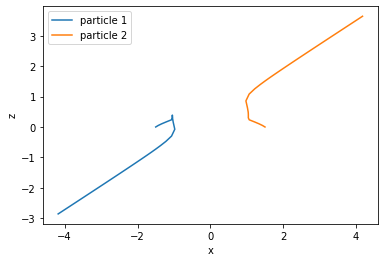

In [70]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
#plt.xlim(-1.2,-1.)
plt.legend()
plt.show()

In [71]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0864186257149586, 10.596453497712508)

In [72]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [73]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.086418625436658, 0.0, -3.40778913239248e-05)

In [74]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [75]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00 -2.16899831e-11 -1.44676937e-10 -2.62469158e-10
 -3.15919291e-10 -3.10666826e-10 -3.11172421e-10 -3.16270121e-10
 -3.26513705e-10 -3.43560735e-10 -3.70134368e-10 -4.11179535e-10
 -4.75782302e-10 -5.84236437e-10 -7.66216868e-10 -1.09253961e-09
 -1.87738447e-09 -4.15486334e-09 -1.00605495e-08 -2.47981202e-08
 -6.21155474e-08 -1.36281525e-07 -2.46168115e-07 -3.17252650e-07
 -4.07949419e-07 -1.02921039e-06 -4.78344293e-06 -5.43353453e-06
 -5.80532884e-06 -6.93221929e-06 -8.05248112e-06 -8.94370290e-06
 -9.66879512e-06 -1.02817771e-05 -1.08105544e-05 -1.12744436e-05
 -1.16904988e-05 -1.20675247e-05 -1.24155062e-05 -1.27386308e-05
 -1.30396957e-05 -1.33222236e-05 -1.35878252e-05 -1.38398324e-05
 -1.40785059e-05 -1.43066247e-05 -1.45242989e-05 -1.47330907e-05
 -1.49337213e-05 -1.51266858e-05 -1.53126719e-05 -1.54915637e-05
 -1.56646329e-05 -1.58325756e-05 -1.59960623e-05 -1.61538667e-05
 -1.63074120e-05 -1.64571655e-05 -1.66035944e-05 -1.67461363e-05
 -1.68850334e-05 -1.70208